In [15]:
#########
import torch
# import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import diffprivlib as dpl
import Other_Mean_Algs as OMA
import P_Trimed_Mean as PTA
from tqdm import tqdm
import itertools
import pickle
import os
import seaborn as sns

<Axes: xlabel='0', ylabel='1'>

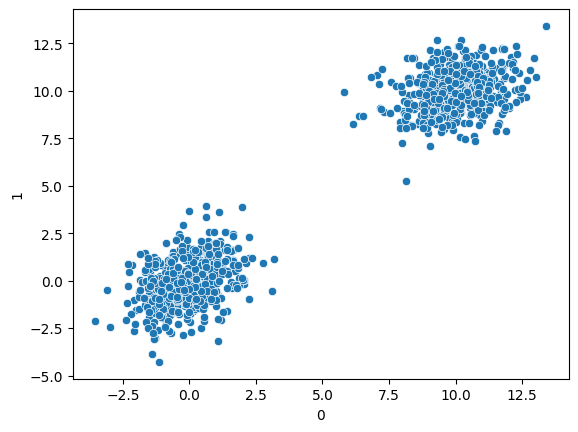

In [16]:
# n=1000
# d=4
# mix = torch.distributions.Categorical(torch.ones(2,))
#         # Stack the means and covariances to define the component distributions
# component_means = torch.stack([torch.zeros(d)-2,torch.zeros(d)+2])
# component_covariances = torch.stack([ get_cov(d), get_cov(d)])
# component_distributions = torch.distributions.MultivariateNormal(component_means, component_covariances)
# D = torch.distributions.MixtureSameFamily(mix, component_distributions)
# X=D.sample(torch.Size([n]))
# X

# Generate random covariance 
def get_cov(d):
    Sigma_k = torch.rand(512, 512)
    Sigma_k = torch.mm(Sigma_k, Sigma_k.t())
    Sigma_k.add_(torch.eye(512))
    # D=torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
    # A=D.sample(torch.Size([d]))
    # # print(A.shape)
    # S=A @ A.t()
    # S=OMA.psd_proj_symm(S)
    return d*Sigma_k/Sigma_k.norm()

# get_cov(2).norm()
## Generate the datasets and set parameters
# ns=[50,100,500,1000,10000]
# ns=[50,100,500,1000,10000]
ns=[50,100,500,1000]
# ns=[50,100,200,300]
# rhos=[1,10,100]
rhos=[0.1,0.5,1]
ds=[2,5,10,50,100]
ds=[1]
Types=[1,2,3,4,5]
# etas=[0,0.01,0.05,0.1,0.25,0.4]
etas=[0,0.05,0.15,0.3]
constants=[5,10,100]
num_runs=50
num_runs=250
# Generate random covariance 
def get_cov(d):
    Sigma_k = torch.rand(d,d)
    Sigma_k = torch.mm(Sigma_k, Sigma_k.t())
    Sigma_k.add_(torch.eye(d))
    # D=torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
    # A=D.sample(torch.Size([d]))
    # # print(A.shape)
    # S=A @ A.t()
    # S=OMA.psd_proj_symm(S)
    return d*Sigma_k/Sigma_k.norm()

# Gen random data 
# 1. Normal, 2. Mixture, 3. Skew, 4. Heavy tail, 5. Contamination
def generate_data(Type,n,d,eta=0.2):
    if Type==1:
        D=torch.distributions.MultivariateNormal(torch.zeros(d), get_cov(d))
        X=D.sample(torch.Size([n]))
    elif Type==2:
        mix = torch.distributions.Categorical(torch.ones(2,))
        # Stack the means and covariances to define the component distributions
        component_means = torch.stack([torch.zeros(d)-5,torch.zeros(d)+5])
        component_covariances = torch.stack([ get_cov(d), get_cov(d)])
        component_distributions = torch.distributions.MultivariateNormal(component_means, component_covariances)
        D = torch.distributions.MixtureSameFamily(mix, component_distributions)
        X=D.sample(torch.Size([n]))
    elif Type==3:
        D = torch.distributions.Exponential(torch.tensor([1.0]))
        X=D.sample(torch.Size((n,d)))-1
    elif Type==4:
        D=torch.distributions.MultivariateNormal(torch.zeros(d), torch.eye(d))
        A=D.sample((d,))
        D = torch.distributions.StudentT(df=3.0)
        X= D.sample(torch.Size((n,d))) @ A.t()
    else:
        D=torch.distributions.MultivariateNormal(torch.zeros(d), get_cov(d))
        X=D.sample(torch.Size([n]))
        X[0:int(n*eta),:]=X[0:int(n*eta),:]+10*np.sqrt(d)
        X=X[torch.randperm(n),:]
    return X


X=generate_data(2,1000,2,eta=0.2)+5
X=torch.squeeze(X)
df=pd.DataFrame(X)
df.head()
sns.scatterplot(data=df,x=0,y=1)
# plt.plot(X)

In [17]:
def one_run(n,d,rho,Type,seed=1,constant=10,eta=0.05):
    torch.manual_seed(seed)
    X=generate_data(Type,n,d,eta=0.2)+5
    # sqrtd=np.sqrt(d)
    # radius=20*sqrtd
    radius=50
    X=X.numpy()
    # print(X.size)
    ## Private trimmed mean
    tm=PTA.private_tm_zCDP_mod_1(X, -radius,radius,rho/4,rho/4,rho/2,beta=1.001,constant=constant,eta=eta,seed=seed)    # tm=PTA.private_tm_zCDP_multi(X, -radius,radius,rho/3,rho/3,rho/3,beta=1.01,constant=constant,eta=eta,seed=seed)
    return tm
    
one_run(1000,1,5,1,seed=1)

5.016502816405988

In [18]:
total=len(ns)*len(ds)*len(rhos)*5*len(constants)*len(etas)
count=0
# num_runs=500
for n in ns:
    print(count/total)
    for d in ds:
        if n>d:
            for rho in rhos:
                for Type in range(5):
                    for constant in constants:
                        for eta in etas:
                        # for Type in [4]:
                            mean_ests=[]
                            file_name='output_tm/tm_'+'n'+str(n)+'_d_'+str(d)+'_rho_'+str(rho)+'_dist_'+str(Type)+'_c_'+str(constant)+'_eta_'+str(eta)+'_nr_'+str(num_runs)+'.pkl'
                            # if True:
                            if not os.path.exists(file_name):
                                for i in range(num_runs):
                                    mean_ests.append(one_run(n,d,rho,Type+1,seed=i+1000,constant=constant,eta=eta))
                                    # Pickling to a file
                                    with open(file_name, 'wb') as file:
                                        pickle.dump(mean_ests, file)
                                count+=1
                            else:
                                count+=1

0.0
0.25
0.5
0.75


In [20]:
# Now analyze the output
# Make a Data frame, rows are n, d, eps, type , columns is the 4 different methods 
# [CoinPress, prime, tm, p_mom]
Types=[1,2,3,4,5]
# ns=ns[:-1]
def get_mse(n,rho,Type,constant,eta):
    d=1
    file_name='output_tm/tm_'+'n'+str(n)+'_d_1_rho_'+str(rho)+'_dist_'+str(Type)+'_c_'+str(constant)+'_eta_'+str(eta)+'_nr_'+str(num_runs)+'.pkl'    # print(file_name)
    try:
        with open(file_name, 'rb') as file:
            mean_list = pickle.load(file)
        list_of_mse=[np.full(d, np.nan) if y is None else y for y in mean_list]
        list_of_mse=[np.full(d, np.nan) if np.array_equal(y,np.ones(d)*-1000)  else y for y in list_of_mse]
        list_of_mse=[((x-5)**2).sum() for x in list_of_mse]
        # list_of_mse[0].shape
        # list_of_mse[0].shape
        MSEs=np.array(list_of_mse)
        nans=np.mean(np.isnan(MSEs))
        if nans>0:
            ss='n'+str(n)+'_d_1_rho_'+str(rho)+'_dist_'+str(Type-1)
            print('for ',ss, ' tm ',nans)
        # print('here')
        return np.nanmean(MSEs)
    except:
        if n>d:
            ss='n'+str(n)+'_d_1_rho_'+str(rho)+'_dist_'+str(Type-1)
            print('could not open '+file_name)
        a = np.empty(1)
        return a.fill(np.nan)

def get_mse_wrapper(x):
    # print(x['n'])
    if(x['rho']==1):
        rho=int(x['rho'])
    else:
        rho=x['rho']
    if x['eta']!=0:
        return get_mse(int(x['n']),rho,int(x['Type']-1),int(x['constant']),x['eta'])
    else:
        return get_mse(int(x['n']),rho,int(x['Type']-1),int(x['constant']),int(x['eta']))


combinations = list(itertools.product(ns, rhos, Types,constants,etas))
results=pd.DataFrame(combinations, columns=['n', 'rho', 'Type','constant','eta'])


# results
# n=100
# d=5
# rho=1
# Type=1

# results[['CP','TM']]= results.apply(get_mse_wrapper, axis=1, result_type='expand')
results['MSE']= results.apply(get_mse_wrapper, axis=1, result_type='expand')

results.columns=[r'$n$',r'$\rho$',r'Distribution',r'$C$',r'$\eta$','MSE']
results.head()

,$n$,$\rho$,Distribution,$C$,$\eta$,MSE
0,50,0.1,1,5,0.00,6.997944
1,50,0.1,1,5,0.05,6.242016
2,50,0.1,1,5,0.15,12.832578
3,50,0.1,1,5,0.30,23.850099
4,50,0.1,1,10,0.00,6.997944


In [21]:

dists2={1: 'Gaussian',
       2: 'Gaussian Mix.',
       3: 'Skewed' ,
       4: 'Heavy Tails',
       5: 'Cont. Gaussian'}

results2=pd.pivot_table(results,index=[r'$n$',r'$\rho$','Distribution',r'$C$'],values='MSE',columns=r'$\eta$').reset_index()
results2.head()

$\eta$,$n$,$\rho$,Distribution,$C$,0.0,0.05,0.15,0.3
0,50,0.1,1,5,6.997944,6.242016,12.832578,23.850099
1,50,0.1,1,10,6.997944,6.242016,12.832578,23.850099
2,50,0.1,1,100,6.997944,6.242016,12.832578,23.850099
3,50,0.1,2,5,16.102688,15.898734,25.248276,31.583746
4,50,0.1,2,10,16.102688,15.898734,25.248276,31.583746


In [22]:



# results2=results2.rename_axis(None, axis=1)
# results2=results2.rename_axis(None, axis=0)
results2['Distribution']=results2['Distribution'].map(dists2)
# results2=results2.drop(r'$\eta$')
# results2[0.0].head()
results2.head()



$\eta$,$n$,$\rho$,Distribution,$C$,0.0,0.05,0.15,0.3
0,50,0.1,Gaussian,5,6.997944,6.242016,12.832578,23.850099
1,50,0.1,Gaussian,10,6.997944,6.242016,12.832578,23.850099
2,50,0.1,Gaussian,100,6.997944,6.242016,12.832578,23.850099
3,50,0.1,Gaussian Mix.,5,16.102688,15.898734,25.248276,31.583746
4,50,0.1,Gaussian Mix.,10,16.102688,15.898734,25.248276,31.583746


In [23]:

# print(results2.columns.name)
results2.columns=[tup for tup in list(results2.columns.to_flat_index())]
results2.head()


,$n$,$\rho$,Distribution,$C$,0.0,0.05,0.15,0.3
0,50,0.1,Gaussian,5,6.997944,6.242016,12.832578,23.850099
1,50,0.1,Gaussian,10,6.997944,6.242016,12.832578,23.850099
2,50,0.1,Gaussian,100,6.997944,6.242016,12.832578,23.850099
3,50,0.1,Gaussian Mix.,5,16.102688,15.898734,25.248276,31.583746
4,50,0.1,Gaussian Mix.,10,16.102688,15.898734,25.248276,31.583746


In [24]:


results2.columns=['$n$', r'$\rho$', 'Distribution',r'$C$']+[r'$\eta$='+str(x) for x in [0.0,  0.05, 0.15,0.3]]
results2.head()

,$n$,$\rho$,Distribution,$C$,$\eta$=0.0,$\eta$=0.05,$\eta$=0.15,$\eta$=0.3
0,50,0.1,Gaussian,5,6.997944,6.242016,12.832578,23.850099
1,50,0.1,Gaussian,10,6.997944,6.242016,12.832578,23.850099
2,50,0.1,Gaussian,100,6.997944,6.242016,12.832578,23.850099
3,50,0.1,Gaussian Mix.,5,16.102688,15.898734,25.248276,31.583746
4,50,0.1,Gaussian Mix.,10,16.102688,15.898734,25.248276,31.583746


In [25]:
for n in ns:
    # Make table
    print('n ',n)
    tmp=results2[results2[r'$n$']==n]
    tmp.index=tmp['Distribution']
    tmp=tmp.drop(columns=[r'$n$','Distribution'])
    tmp=tmp.style.format(decimal='.', thousands='.', precision=4)
    latex_table =tmp.to_latex()
    print(latex_table)

n  50
\begin{tabular}{lrrrrrr}
 & $\rho$ & $C$ & $\eta$=0.0 & $\eta$=0.05 & $\eta$=0.15 & $\eta$=0.3 \\
Distribution &  &  &  &  &  &  \\
Gaussian & 0.1000 & 5 & 6.9979 & 6.2420 & 12.8326 & 23.8501 \\
Gaussian & 0.1000 & 10 & 6.9979 & 6.2420 & 12.8326 & 23.8501 \\
Gaussian & 0.1000 & 100 & 6.9979 & 6.2420 & 12.8326 & 23.8501 \\
Gaussian Mix. & 0.1000 & 5 & 16.1027 & 15.8987 & 25.2483 & 31.5837 \\
Gaussian Mix. & 0.1000 & 10 & 16.1027 & 15.8987 & 25.2483 & 31.5837 \\
Gaussian Mix. & 0.1000 & 100 & 16.1027 & 15.8987 & 25.2483 & 31.5837 \\
Skewed & 0.1000 & 5 & 7.9827 & 5.6974 & 12.1654 & 25.6706 \\
Skewed & 0.1000 & 10 & 7.9827 & 5.6974 & 12.1654 & 25.6706 \\
Skewed & 0.1000 & 100 & 7.9827 & 5.6974 & 12.1654 & 25.6706 \\
Heavy Tails & 0.1000 & 5 & 5.0993 & 5.9785 & 13.3371 & 23.3229 \\
Heavy Tails & 0.1000 & 10 & 5.0993 & 5.9785 & 13.3371 & 23.3229 \\
Heavy Tails & 0.1000 & 100 & 5.0993 & 5.9785 & 13.3371 & 23.3229 \\
Cont. Gaussian & 0.1000 & 5 & 10.6869 & 8.0391 & 21.0777 & 22.6884 \\


In [12]:
# now turn 4 columns into 1 
results['lMSE']=np.log(results['MSE'])
def make_plot(d,Type,rho,n_t=0):
    tmp=results[results['d']==d]
    tmp=tmp[tmp['Type']==Type]
    tmp=tmp[tmp['rho']==rho]
    tmp=tmp[tmp['n']>n_t]
    # print(tmp.head())
    tmp.dropna()
    sns.lineplot(data=tmp,y='lMSE',x='n',hue='eta',style='constant')
    # plt.ylim((0,tmp.MSE.max()))
    plt.show()


# now turn 4 columns into 1 
def make_plot_2(d,Type,rho,n,log=False):
    tmp=results[results['d']==d]
    tmp=tmp[tmp['Type']==Type]
    tmp=tmp[tmp['rho']==rho]
    tmp=tmp[tmp['n']==n]
    # print(tmp.head())
    tmp.dropna()
    if log:
        sns.lineplot(data=tmp,y='lMSE',x='constant',hue='eta')
    else:
        sns.lineplot(data=tmp,y='MSE',x='constant',hue='eta')
    # sns.lineplot(data=tmp,y='lMSE',x='constant',hue='eta')
    # plt.ylim((0,tmp.MSE.max()))
    plt.show()


def make_plot_3(d,Type,rho,n,main='',log=False):
    tmp=results[results['d']==d]
    tmp=tmp[tmp['Type']==Type]
    tmp=tmp[tmp['rho']==rho]
    # tmp=tmp[tmp['n']==n]
    # print(tmp.head())
    tmp.dropna()
    # sns.lineplot(data=tmp,y='lMSE',x='eta',hue='constant')
    if log:
        sns.lineplot(data=tmp,y='lMSE',x='eta', style='constant')
    else:
        sns.lineplot(data=tmp,y='MSE',x='eta', style='constant')
    # ax.lines.set_linestyle("--")
    plt.title(main)
    # plt.ylim((0,tmp.MSE.max()))
    plt.show()


# make_plot(1,1,1,0)
# make_plot(1,1,1,0)
# make_plot(1,2,1,0)
# make_plot(1,3,1,0)
# make_plot(1,4,1,0)
# make_plot(1,5,1,0)

# # make_plot(1,1,1,100)
# make_plot_2(1,1,1,1000)
# make_plot_2(1,2,1,1000)
# make_plot_2(1,3,1,1000)
# make_plot_2(1,4,1,1000)
# make_plot_2(1,5,1,1000)


# make_plot_3(1,1,100,1000)
# make_plot_3(1,2,100,1000)
# make_plot_3(1,3,100,1000)
# make_plot_3(1,4,100,1000)
# make_plot_3(1,5,100,1000)


# make_plot_3(1,1,100,100)
# make_plot_3(1,2,100,100)
# make_plot_3(1,3,100,100)
# make_plot_3(1,4,100,100)
# make_plot_3(1,5,100,100)


# make_plot_3(1,1,1,100)
# make_plot_3(1,2,1,100)
# make_plot_3(1,3,1,100)
# make_plot_3(1,4,1,100)
# make_plot_3(1,5,1,100)


# for rho in rhos:
#     for i in Types:
#         # for n in ns:
#         make_plot_3(1,i,rho,n,main='Type '+str(i)+' rho '+str(rho)+' n '+str(n),log=True)

In [13]:
# now turn 4 columns into 1 
def make_plot(d,Type,rho,n_t=0):
    tmp=results[results['d']==d]
    tmp=tmp[tmp['Type']==Type]
    tmp=tmp[tmp['rho']==rho]
    tmp=tmp[tmp['n']>n_t]
    # print(tmp.head())
    tmp.dropna()
    sns.lineplot(data=tmp,y='MSE',x='n',hue='eta',style='constant')
    # plt.ylim((0,tmp.MSE.max()))
    plt.show()


# now turn 4 columns into 1 
def make_plot_2(d,Type,rho,n):
    tmp=results[results['d']==d]
    tmp=tmp[tmp['Type']==Type]
    tmp=tmp[tmp['rho']==rho]
    tmp=tmp[tmp['n']==n]
    # print(tmp.head())
    tmp.dropna()
    sns.lineplot(data=tmp,y='MSE',x='constant',hue='eta')
    # plt.ylim((0,tmp.MSE.max()))
    plt.show()


def make_plot_3(d,Type,rho,n):
    tmp=results[results['d']==d]
    tmp=tmp[tmp['Type']==Type]
    tmp=tmp[tmp['rho']==rho]
    tmp=tmp[tmp['n']==n]
    # print(tmp.head())
    tmp.dropna()
    sns.lineplot(data=tmp,y='MSE',x='eta',hue='constant')
    # plt.ylim((0,tmp.MSE.max()))
    plt.show()



# make_plot(10,1,1,200)
# make_plot_2(10,1,1,100)
# make_plot_2(10,2,1,100)
# make_plot_2(10,3,1,100)
# make_plot_2(10,4,1,100)
# make_plot_2(10,5,1,100)



# make_plot_2(10,1,1,10000)
# make_plot_2(10,2,1,10000)
# make_plot_2(10,3,1,10000)
# make_plot_2(10,4,1,10000)
# make_plot_2(10,5,1,10000)

# make_plot_3(10,1,100,1000)
# make_plot_3(10,2,100,1000)
# make_plot_3(10,3,100,1000)
# make_plot_3(10,4,100,1000)
# make_plot_3(10,5,100,1000)


# make_plot_2(10,1,100,10000)
# make_plot_2(10,2,100,10000)
# make_plot_2(10,3,100,10000)
# make_plot_2(10,4,100,10000)
# make_plot_2(10,5,100,10000)


# make_plot_2(50,1,100,1000)
# make_plot_2(50,2,100,1000)
# make_plot_2(50,3,100,1000)
# make_plot_2(50,4,100,1000)
# make_plot_2(50,5,100,1000)


# make_plot(10,2,1)
# make_plot(10,3,1)
# make_plot(10,4,1)
# make_plot(10,5,1)
# results_melted.head()
# results_melted.head(100)
# results_melted.MSE.unique()



In [38]:
# # now turn 4 columns into 1 
# results['lMSE']=np.log(results['MSE'])
# def make_plot(d,Type,rho,n_t=0):
#     tmp=results[results['d']==d]
#     tmp=tmp[tmp['Type']==Type]
#     tmp=tmp[tmp['rho']==rho]
#     tmp=tmp[tmp['n']>n_t]
#     # print(tmp.head())
#     tmp.dropna()
#     sns.lineplot(data=tmp,y='lMSE',x='n',hue='eta',style='constant')
#     # plt.ylim((0,tmp.MSE.max()))
#     plt.show()


# # now turn 4 columns into 1 
# def make_plot_2(d,Type,rho,n,log=False):
#     tmp=results[results['d']==d]
#     tmp=tmp[tmp['Type']==Type]
#     tmp=tmp[tmp['rho']==rho]
#     tmp=tmp[tmp['n']==n]
#     # print(tmp.head())
#     tmp.dropna()
#     if log:
#         sns.lineplot(data=tmp,y='lMSE',x='constant',hue='eta')
#     else:
#         sns.lineplot(data=tmp,y='MSE',x='constant',hue='eta')
#     # sns.lineplot(data=tmp,y='lMSE',x='constant',hue='eta')
#     # plt.ylim((0,tmp.MSE.max()))
#     plt.show()


# def make_plot_3(d,Type,rho,n,main='',log=False):
#     # tmp=results[results['d']==d]
#     tmp=results[results['Distribution']==Type]
#     tmp=tmp[tmp[r'$\rho$']==rho]
#     tmp=tmp[tmp[r'$n$']==n]
#     # print(tmp.head())
#     tmp.dropna()
#     # sns.lineplot(data=tmp,y='lMSE',x='eta',hue='constant')
#     if log:
#         sns.lineplot(data=tmp,y='lMSE',x=r'$\eta$', style=r'$C$')
#     else:
#         sns.lineplot(data=tmp,y='MSE',x=r'$\eta$', style=r'$C$')
#     # ax.lines.set_linestyle("--")
#     plt.title(main)
#     # plt.ylim((0,tmp.MSE.max()))
#     plt.show()

# for n in ns:
#     for rho in rhos:
#         for i in Types:
#         # for n in ns:
#             make_plot_3(1,i,rho,n,main='Distribution '+str(i)+' rho '+str(rho)+' n '+str(n),log=True)

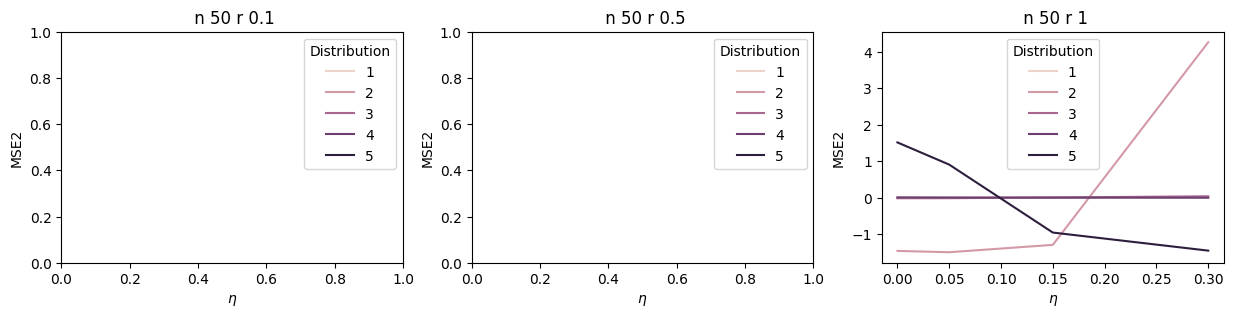

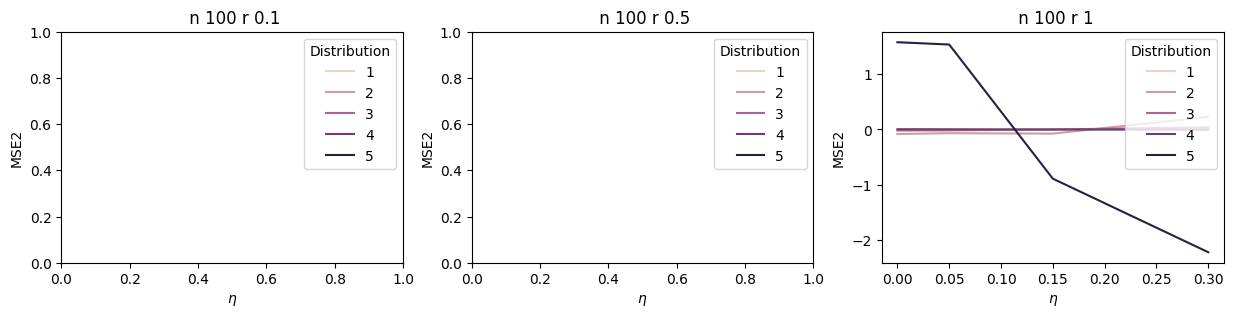

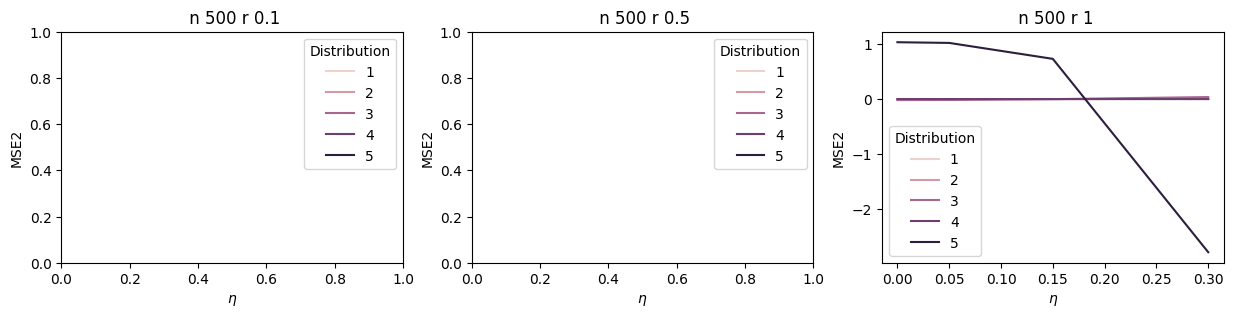

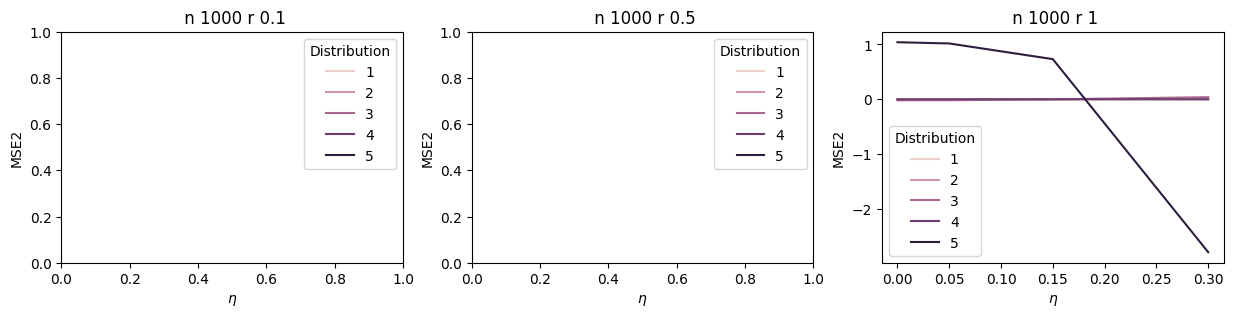

In [ ]:

def make_plot_3(d,Type,rho,n,main='',log=True):
    # tmp=results[results['d']==d]
    # tmp=results[results['Distribution']<4].copy()
    tmp=results[results['Distribution']<6].copy()
    tmp=tmp[tmp[r'$C$']==100].copy()
    # tmp=tmp[tmp[r'$\rho$']==rho]
    tmp=tmp[tmp[r'$n$']==n].copy()
    # print(tmp.head())
    tmp.dropna()
    # sns.lineplot(data=tmp,y='lMSE',x='eta',hue='constant')
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    tmp2=tmp.copy()
    for i in range(3):
        tmp3=tmp2[tmp2[r'$\rho$']==rhos[i]].copy()
        means=tmp3[['MSE','Distribution']].groupby('Distribution').mean()
        tmp3['MSE2']=tmp3['MSE']
        # print(tmp['MSE2'])
        # print(means)
        # for j in [1,2,3]:
        for j in [1,2,3,4,5]:
            # print(float(means.iloc[j-1]))
            tmp3.loc[tmp3['Distribution']==j,'MSE2']=tmp3.loc[tmp3['Distribution']==j,'MSE2']-float(means.iloc[j-1].iloc[0])
        sns.lineplot(data=tmp3,y='MSE2',x=r'$\eta$', hue='Distribution',ax=axes[i])
    # ax.lines.set_linestyle("--")
        axes[i].set_title(main+' r '+str(rhos[i]))
    # plt.ylim((0,tmp.MSE.max()))
    plt.show()

for n in ns:
        # for i in Types:
        # for n in ns:
    make_plot_3(1,i,rho,n,main=' n '+str(n),log=False)
# D 5 and 4 lower is better
